In [4]:
# Importing necessary libraries for the project
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

# Checking the number of available GPUs
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version: 2.10.0
Num GPUs Available:  1


In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as pyplot
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import to_categorical

In [6]:
# Load dataset
df = pd.read_csv('Andres/data_csv/fer.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


C:\Users\Andres\AppData\Local\Temp\ipykernel_17424\2404698305.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')


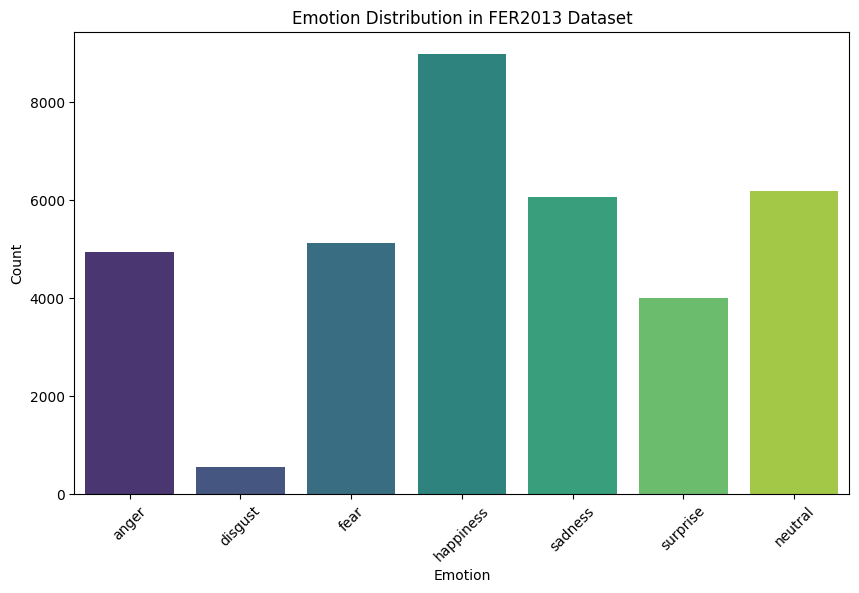

In [7]:
# Label emotions
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

# Create a bar graph of emotion counts
emotion_counts = df.emotion.value_counts().sort_index()
fig = pyplot.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')
pyplot.title('Emotion Distribution in FER2013 Dataset')
pyplot.xlabel('Emotion')
pyplot.ylabel('Count')
pyplot.xticks(ticks=np.arange(len(emotion_label_to_text)), labels=[emotion_label_to_text[i] for i in range(len(emotion_label_to_text))], rotation=45)
pyplot.show()

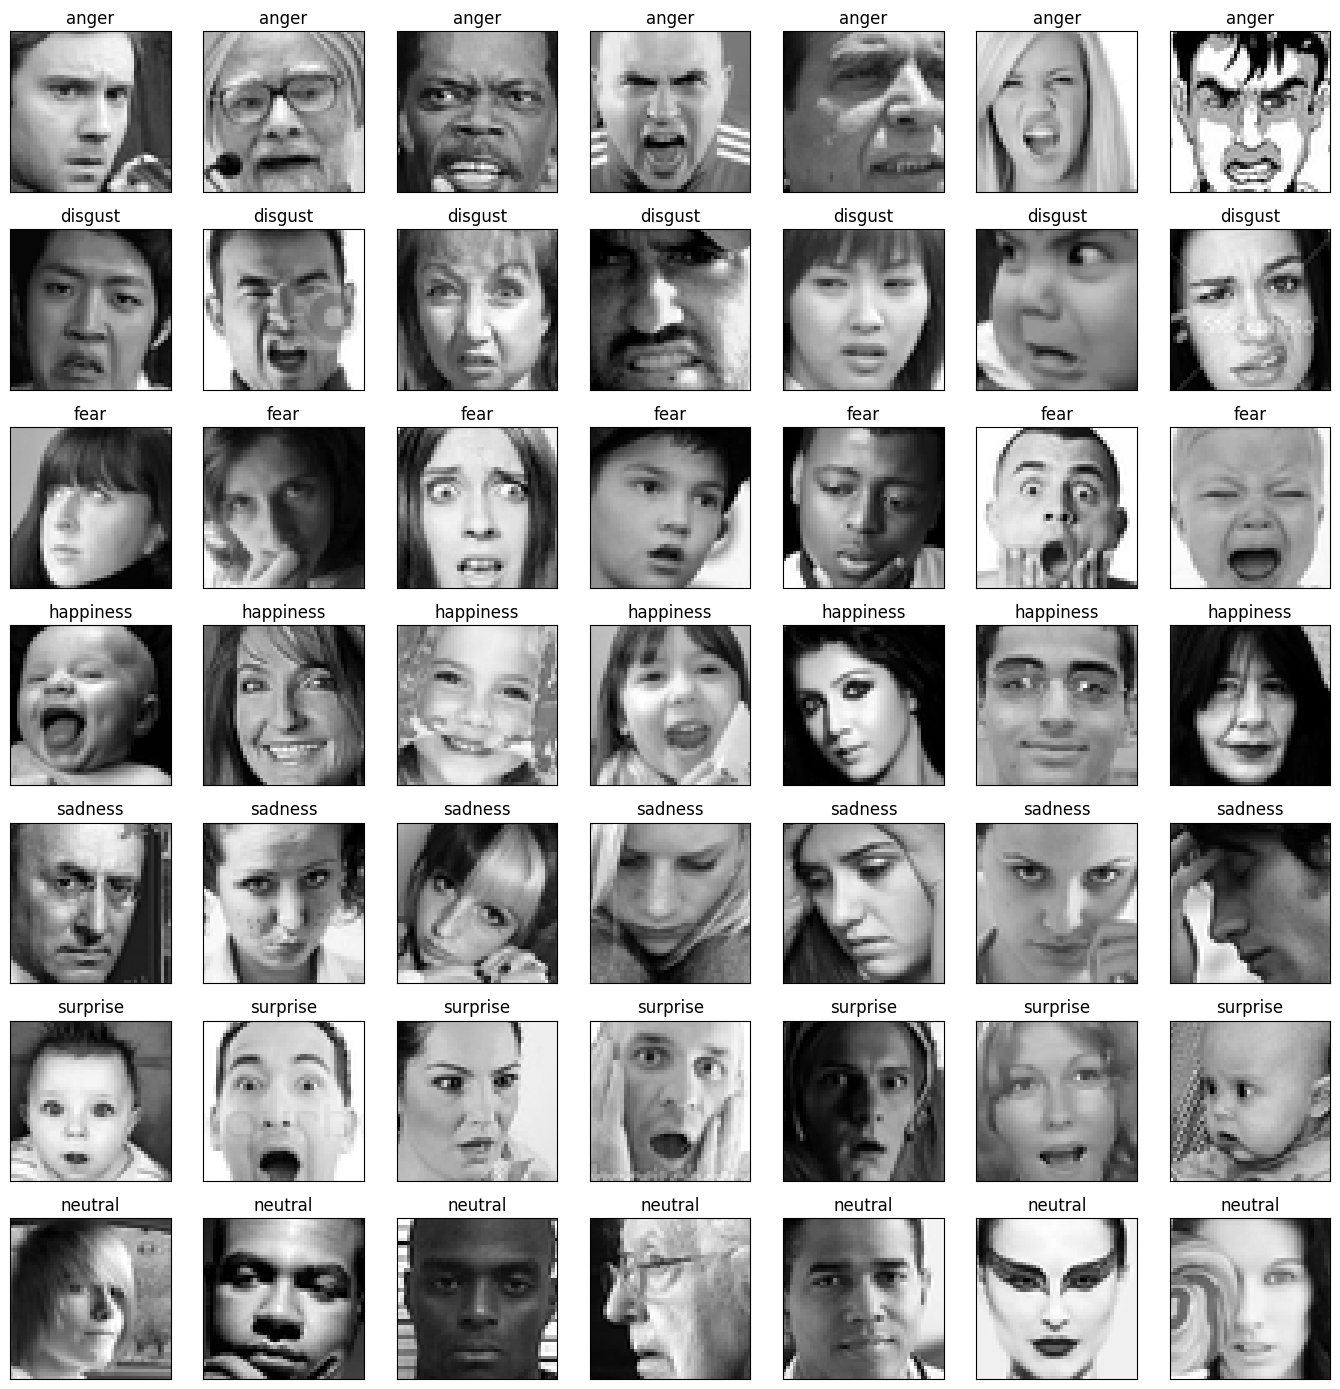

In [8]:
# Display example images from each emotion category
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [9]:
# Modify image format for use in CNN with Keras
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)
img_array.shape

(35887, 48, 48, 1)

In [10]:
# Encode labels
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

In [11]:
# Split and normalize data
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels, shuffle=True, stratify=img_labels, test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

X_train = X_train / 255.
X_valid = X_valid / 255.

In [12]:
# Deep Convolutional Neural Network using dropout, ELU, he_normal, and BatchNormalization
def build_net(optim):
    net = Sequential(name='DCNN')
    
    net.add(Input(shape=(img_width, img_height, img_depth), name='input_layer'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))

    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))

    net.add(Dropout(0.6, name='dropout_4'))

    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )

    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

    net.summary()

    return net

In [13]:
# Define early stopping condition and learning rate behavior
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [14]:
# Used to slightly augment images during training
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [15]:
# Train model
batch_size = 32
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

model = build_net(optims[1])
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

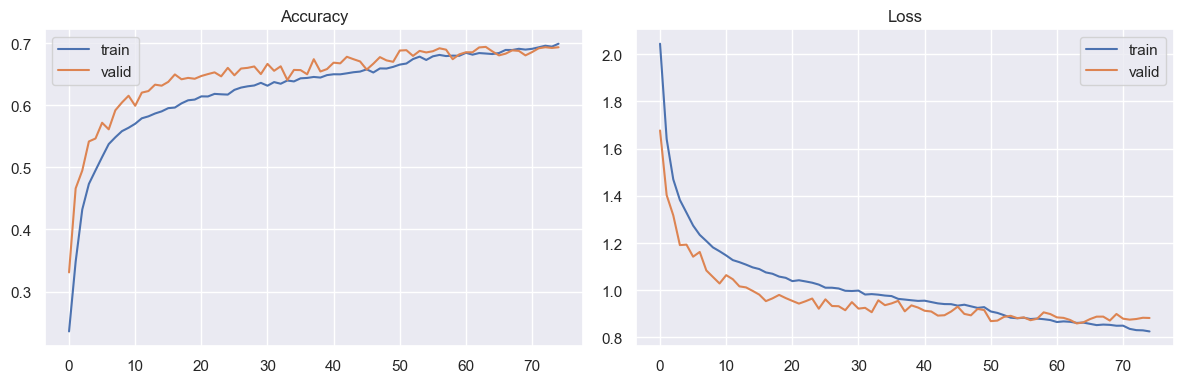

113/113 [==============================] - 0s 2ms/step
Total wrong validation predictions: 1099


              precision    recall  f1-score   support

           0       0.62      0.67      0.64       495
           1       0.72      0.53      0.61        55
           2       0.60      0.43      0.50       512
           3       0.89      0.87      0.88       899
           4       0.58      0.59      0.58       608
           5       0.76      0.78      0.77       400
           6       0.62      0.74      0.67       620

    accuracy                           0.69      3589
   macro avg       0.68      0.66      0.67      3589
weighted avg       0.69      0.69      0.69      3589



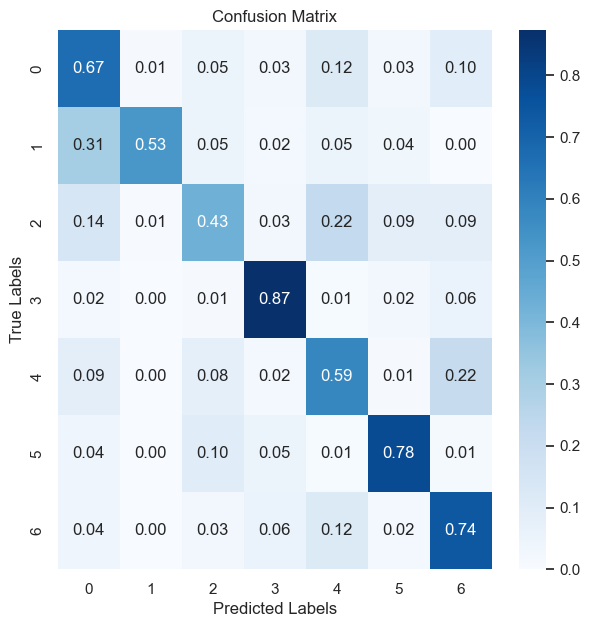

In [16]:
# Evaluate the model
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train', ax=ax)
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid', ax=ax)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train', ax=ax)
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid', ax=ax)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

# Predict class probabilities
yhat_valid_prob = model.predict(X_valid)

# Convert probabilities to class labels
yhat_valid = np.argmax(yhat_valid_prob, axis=1)

# Convert true labels to class labels
y_true = np.argmax(y_valid, axis=1)

# Plot confusion matrix using seaborn
conf_mat = confusion_matrix(y_true, yhat_valid, normalize='true')

fig, ax = pyplot.subplots(figsize=(7, 7))
sns.heatmap(conf_mat, annot=True, fmt='.2f', cmap='Blues', ax=ax)
pyplot.title('Confusion Matrix')
pyplot.xlabel('Predicted Labels')
pyplot.ylabel('True Labels')
pyplot.savefig("confusion_matrix_dcnn.png")

# Print the total number of wrong predictions
print(f'Total wrong validation predictions: {np.sum(y_true != yhat_valid)}\n\n')

# Print classification report
print(classification_report(y_true, yhat_valid))

In [1]:
# Saving the model
model.save('emotion_model_main.h5')

NameError: name 'model' is not defined